In [1]:
import torch
from SPN import SPN
from matplotlib import pyplot as plt
import utils
from torchinfo import summary
import numpy as np
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO 
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
from Anneal import anneal
import pickle
import time

### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [2]:
# !pip install nbformat --upgrade


Running on:  cuda
num_drones = 800	num_facilities = 120	dim = 2


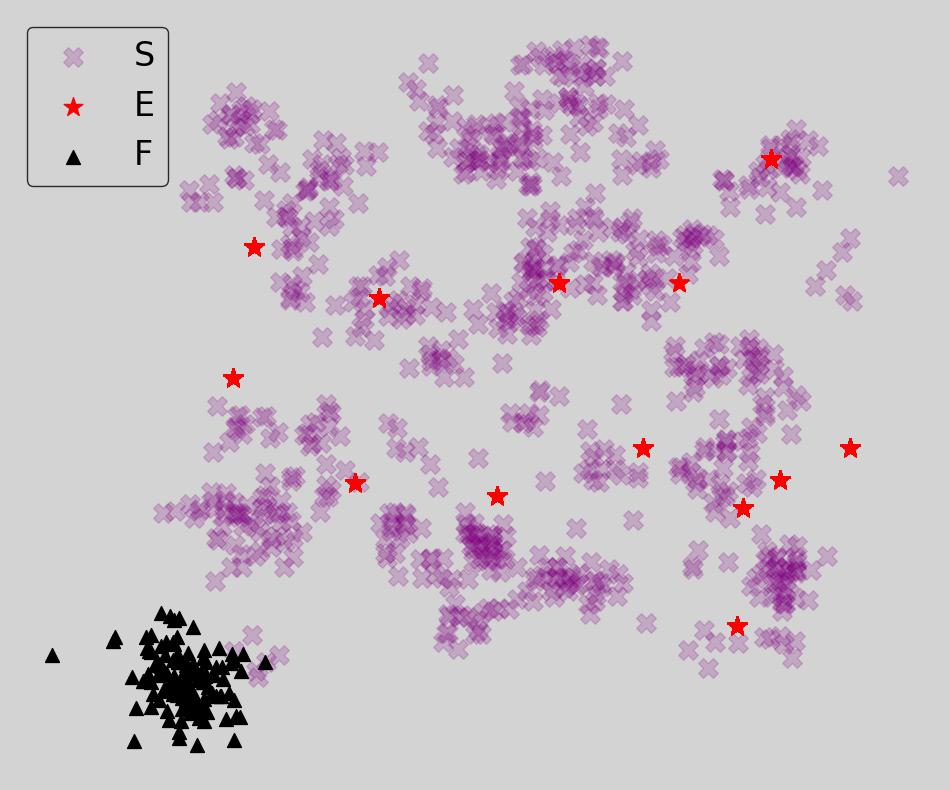

In [3]:
seed=3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

num_drones = 800
n_drone_clusters = 70
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 120
num_distinct_ends = 12
dim_ = 2
print(f"num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}")
# print(drone_cluster_split)
START_locs, F_base, END_locs = generate_dataset(
    num_drones, 
    n_drone_clusters, 
    drone_cluster_split, 
    num_facilities, 
    dim_, 
    device, 
    seed,
    drone_cluster_std_range=[0.02, 0.03], 
    F_noise_std=0.05,
    num_distinct_ends=num_distinct_ends
)

# torchFLPO_2_numpyFLPO(START_locs, END_locs, F_base, dim_, scale=1.0)

plot_UAV_FLPO(START_locs, END_locs, F_base, (12,10))
# # plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Load the SPN Module

In [5]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
print("SPN loaded on: ", spn.device)
print(summary(spn))

Model created.
SPN loaded on:  cuda
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│    │

### Optimization loop for a single beta


In [ ]:
# optim_iters = 200
# optim_step = 0.01
# b_min = 1e-3
# beta = 1e3
# tol = 1e-3

# Y_arr_adam, FreeEnergy_adam, G_adam = GD.Adam_at_beta(
#     F_base, START_locs, END_locs, spn, optim_iters,
#     optim_step, tol=tol, allowPrint=True, return_list= True)




Using VRPNet and Path Sampling

In [ ]:
# optim_iters = 100
# optim_step = 0.02
# b_min = 1e4
# beta = 1e4
# tol = 0.001
# n_path_samples = 8

# tic = time.time()
# F_base0_highbeta = F_base.clone().detach().requires_grad_(True)
# F_base_sampling, FreeEnergy_sampling, G_sampling = GD.sampling_GD_at_beta_auto_diff(
#     F_base0_highbeta,
#     START_locs,
#     END_locs,
#     spn,
#     n_path_samples=n_path_samples,
#     beta=beta,
#     stepsize=optim_step,
#     iters=optim_iters,
#     tol=tol,
#     allowPrint=True
#     )
# toc = time.time()
# runtime_high_beta = toc-tic


In [ ]:
# plot_UAV_FLPO(START_locs, END_locs, F_base_sampling, (12,6))


### Save the high beta results (plotting done in plot_res.ipynb)

In [ ]:
scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
file_path0 = "AAAI26_res/high_beta_res/" + scenario
print(file_path0)
# file_path0 = "AAAI26_res/low_beta_res/" + scenario

high_beta_res_data = {
    "START_locs":START_locs,
    "END_locs":END_locs,
    "F_base":F_base_sampling,
    "n_ends":num_distinct_ends,
    "F_base0":F_base0_highbeta,
    "optim_method":"sampling_GD_at_beta_auto_diff",
    "optim_iters":optim_iters,
    "optim_step":optim_step,
    "beta":beta,
    "optim_tol":tol,
    "n_path_samples":n_path_samples,
    "Free_energy_final":FreeEnergy_sampling,
    "Gradient_final":G_sampling,
    "runtime":runtime_high_beta
}

with open(file_path0, 'wb') as file:
    pickle.dump(high_beta_res_data, file)

### Annealing loop implementation
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

beta: 1.0000e-03	FreeE: -2564.4402	Grad: 1.0951e-01
beta: 1.0000e-02	FreeE: -256.0414	Grad: 7.1650e-02
beta: 1.0000e-01	FreeE: -25.1995	Grad: 3.0869e-02
beta: 1.0000e+00	FreeE: -2.1520	Grad: 5.5155e-02
beta: 1.0000e+01	FreeE: -0.1070	Grad: 6.9896e-02
beta: 1.0000e+02	FreeE: 0.0182	Grad: 1.0767e-02
beta: 1.0000e+03	FreeE: 0.0300	Grad: 3.8320e-03
beta: 1.0000e+04	FreeE: 0.0302	Grad: 2.7332e-03


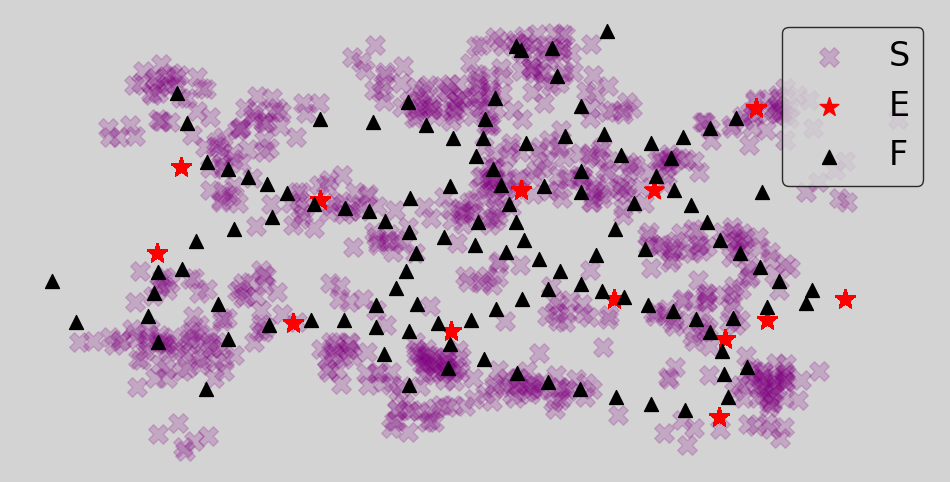

In [6]:
beta_min = 1e-3 
beta_max = 1e4
beta_grow = 10
optim_iters = 100
optim_step = 0.01 # 0.1 for gd0, sampling_gd, use < 0.01 for the other two optimizers 
optim_name = "sampling_auto_diff"
tol = 0.001
n_path_samples = 8

tic = time.time()
F_base0_anneal = F_base.clone().detach().requires_grad_(True)
Y_arr, b_arr, F_arr = anneal( 
        F_base0_anneal, 
        START_locs, 
        END_locs, 
        spn,  
        optim_iters, 
        optim_step, 
        beta_min, 
        beta_max, 
        beta_grow, 
        tol=tol, 
        optimizer_name=optim_name, 
        n_path_samples=n_path_samples, 
        allowPrint=True 
    ) 
toc = time.time()
runtime_anneal = toc-tic
plot_UAV_FLPO(START_locs, END_locs, Y_arr[-1], (12,6))


### Save the annealing results (plotting done in plot_res.ipynb)

In [ ]:
file_path1 = "AAAI26_res/annealing_res/" + scenario
print(f'filepath: {file_path1}')

annealing_res_data = {
    "START_locs":START_locs,
    "END_locs":END_locs,
    "Y_arr":Y_arr,
    "b_arr":b_arr,
    "F_arr":F_arr,
    "F_bas0":F_base0_anneal,
    "optim_method":optim_name,
    "optim_iters":optim_iters,
    "optim_step":optim_step,
    "optim_tol":tol,
    "n_path_samples":n_path_samples,
    "runtime":runtime_anneal
}

with open(file_path1, 'wb') as file:
    pickle.dump(annealing_res_data, file)

### Animation results moved to plot_res.ipynb